# GLCP

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

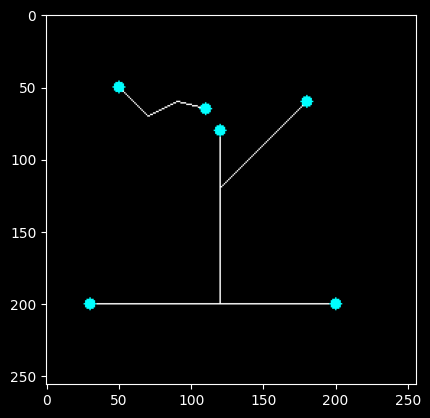

In [21]:
def extract_endpoints(skel: np.ndarray) -> np.ndarray:
    bin_skel = (skel > 0).astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    neighbor_count = cv2.filter2D(bin_skel, -1, kernel)
    endpoints = np.logical_and(bin_skel == 1, neighbor_count == 2)
    return endpoints.astype(np.uint8)

# 1. ダミーのスケルトン画像を作成
H, W = 256, 256
skel = np.zeros((H, W), dtype=np.uint8)
cv2.line(skel, (30, 200), (200, 200), 255, 1)
cv2.line(skel, (120, 200), (120, 80), 255, 1)
cv2.line(skel, (120, 120), (180, 60), 255, 1)
pts = np.array([[50, 50], [70, 70], [90, 60], [110, 65]], np.int32).reshape((-1, 1, 2))
cv2.polylines(skel, [pts], False, 255, 1)

# 2. エンドポイント抽出
endpoints = extract_endpoints(skel)

# 3. カラー画像にしてプロット
vis = cv2.cvtColor(skel, cv2.COLOR_GRAY2BGR)

ys, xs = np.where(endpoints == 1)
for x, y in zip(xs, ys):
    cv2.circle(vis, (x, y), 4, (0, 255, 255), thickness=-1)  # 黄(BGR)

plt.imshow(vis)
